In [72]:
from langgraph.graph import StateGraph , START , END
from typing import TypedDict , Literal
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel , Field
from pprint import pprint
load_dotenv()

True

In [52]:
generator_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite")
optimizer_llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro")
evaluator_llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro")


In [53]:
class Needs(TypedDict):
    topic: str
    question: str
    question_goodness : Literal['very_good', 'good', 'poor']
    optimize_iteration: int
    max_iter: int
    evaluate_feedback: str
    goodness_message: str
    answer: str
    answer_quality: Literal['Execelent' , 'Nice', 'Reject']
    answer_quality_message: str
    nice_iter: int

In [54]:
def generate(state: Needs) -> Needs:
    topic= state['topic']
    prompt= f"""
    You are a question designer for an International Science Innovation Hunt. 
    Your task is to create one original, experimental, and psychologically engaging science question 
    that challenges participants to think beyond textbook knowledge.

    Regulations:
    - The question must be centered on the topic: {topic}
    - The question must be **less than 250 words**
    - The question must be **novel and not a recycled or old competition question**
    - It should blend **scientific reasoning** with **psychological or behavioral insight**
    - It should encourage **new ideas** or **hypothetical experiments**, not rote recall
    - The framing should be **open-ended but testable**, pushing participants to propose creative solutions
    - Avoid trivia; focus on **“what if” scenarios**, **thought experiments**, or **design challenges**

    Output format:
    - **Question:** [Write the question here]  
    """

    result= generator_llm.invoke(prompt).content
    return {'question': result}

In [55]:
class Evaluation_techniques(BaseModel):
    question_state: Literal['very_good', 'good', 'poor'] = Field(description='What is the level of question asked where very_good is for best')
    feeback: str = Field(description= 'Summary the question feeback within 50 words')

structured_evaluator= evaluator_llm.with_structured_output(Evaluation_techniques)

def evaluate(state: Needs) -> Needs:
    question= state['question']
    prompt= f"""
    You are an evaluator for International Science Innovation Hunt questions. 
    Your task is to assess the quality of a proposed competition question : {question} and 
    rate it as "very_good", "good", or "poor" based on the following regulations:

    Regulations:
    - If the question is longer than 250 words → automatically "poor".
    - If the question is recycled, common, or often asked → "poor".
    - If the question is acceptable but only moderately original or lacks depth → "good".
    - If the question is concise, novel, experimental, and psychologically engaging → "very_good".

    Output format:
    - **Rating:** [very_good / good / poor]
    """
    results= structured_evaluator.invoke(prompt)
    return {'evaluate_feedback': results.feeback , 'question_goodness': results.question_state}

In [56]:
def optimizer(state: Needs) -> Needs:
    feedback= state['evaluate_feedback']
    topic= state['topic']
    question= state['question']
    prompt= f""" 
    You are an optimizer for competition science questions. 
    Your task is to improve the draft question based on the given topic and evaluator feedback.

    Inputs:
    - Topic: {topic}
    - Feedback: {feedback}
    - Draft Question: {question}

    Regulations:
    - Keep the improved question under 250 words.
    - Ensure it is novel (not a recycled or common competition question).
    - Align it closely with the given topic.
    - Incorporate the feedback directly into the revision.
    - Output only the improved question text, nothing else.

"""
    result= optimizer_llm.invoke(prompt).content
    counting= state['optimize_iteration'] + 1 
    return {'optimize_iteration':counting , 'question' : result}

In [57]:
def kick_out(state: Needs) -> Needs:
    return {'goodness_message': "Sorry You question is not for this level of competition for now better luck next time"}

In [58]:
def tracking_conditions(state: Needs) -> Literal['very_good', 'good','poor']:
    if state['question_goodness'] == 'very_good':
        return 'very_good'
    elif state['question_goodness'] == 'good' and state['optimize_iteration'] < state['max_iter']:
        return 'good'
    else:
        return 'poor'

In [59]:
def good_question(state: Needs) -> Needs:
    return {'goodness_message' : 'Congratulations ! Your question has been selected now its time to frame its answer'}

In [60]:
def good_ques_answer_generating(state: Needs) -> Needs:
    question= state['question']
    prompt= f"""   
    You are a participant in an International Science Innovation Hunt. 
    Your task is to provide a **brief, clear, and insightful answer** to the given competition question. 

    Regulations:
    - Keep the answer under 150 words.
    - Focus on clarity and originality, not length.
    - Avoid repeating the question; go straight to the answer.
    - Use simple, precise language suitable for a competition setting.
    - Provide reasoning or an example if possible, but stay concise.

    Question: {question}

    Output:
    - **Answer:** [Write your brief answer here]
     """
    results= generator_llm.invoke(prompt).content
    return {'answer':results}

In [61]:
class Answer_level_checking(BaseModel):
    quality: Literal['Execelent', 'Nice', 'Reject'] = Field(description='Evaluate the quality of Answer')

quality_checking_llm= evaluator_llm.with_structured_output(Answer_level_checking)
def answer_level(state: Needs) -> Literal['Execelent', 'Nice', 'Reject']:
    goodness= quality_checking_llm.invoke(state['answer']).quality
    if goodness == 'Execelent':
        return 'Execelent'
    elif goodness == 'Nice':
        return 'Nice'
    else:
        return 'Reject'

In [62]:
def execelent_appreciation(state: Needs) -> Needs:
    return {'answer_quality_message' : '''Hii your question and its answer is so much interesting ... You thinking power is so good , we will contact you later in  "Full potential of knowledge CampionShip" in India '''}

In [63]:
def reject_participation_letter(state: Needs) -> Needs:
    return {'answer_quality_message': ''' Your question is too good but We think you are not prepare for answer .... Well Done and be better with more correct answer next time... Created with ♥'''}

In [64]:
def Nice_second_chance(state: Needs) -> Needs:
    previous_answer= state['answer']
    prompt= f'Your previous question is this {previous_answer} and this is the feedback - {state['evaluate_feedback']} and now reframe short answer within 150 words but it should be more better'
    results= generator_llm.invoke(prompt).content
    iterations= state['nice_iter'] + 1
    return {'answer': results , 'nice_iter':iterations} 

In [65]:
class Nice_checking_again(BaseModel):
    do_or_die : Literal['calculate_again','reject'] = Field(description='Evaluate the answer')

nice_llm= evaluator_llm.with_structured_output(Nice_checking_again)

def compete_for_second_chance(state: Needs) -> Literal['calculate_again', 'reject']:
    checking= nice_llm.invoke(state['answer'])
    if checking.do_or_die == 'calculate_again' and state['nice_iter'] < 3:
        return 'calculate_again'
    else:
        return 'reject'

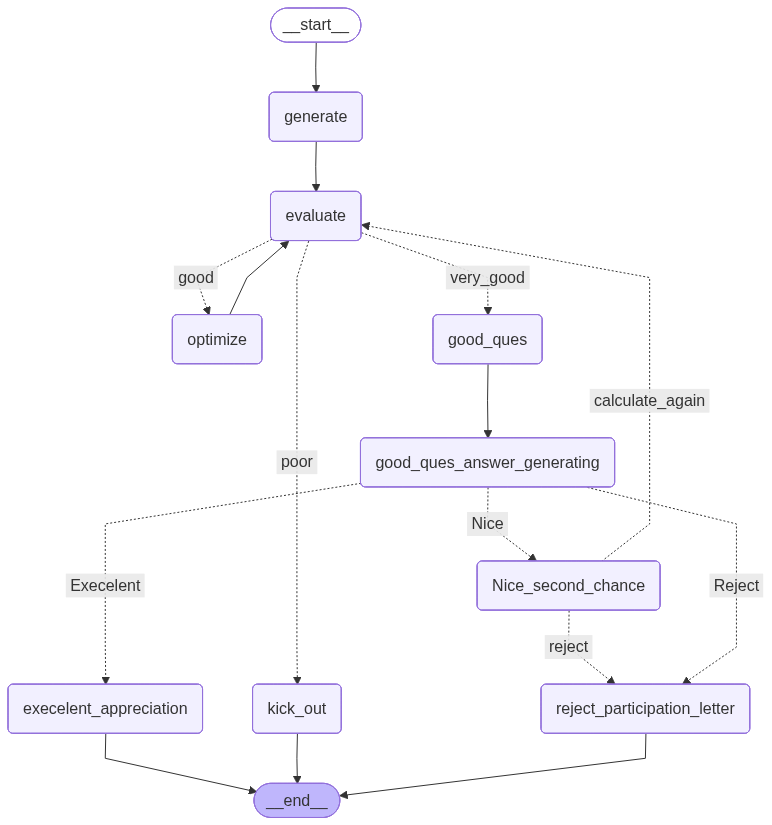

In [66]:
graphs= StateGraph(Needs)
graphs.add_node('generate', generate)
graphs.add_node('evaluate', evaluate)
graphs.add_node('optimize', optimizer)
graphs.add_node('kick_out', kick_out)
graphs.add_node('good_ques', good_question)
graphs.add_node('execelent_appreciation', execelent_appreciation)
graphs.add_node('Nice_second_chance', Nice_second_chance)
graphs.add_node('reject_participation_letter', reject_participation_letter )
graphs.add_node('good_ques_answer_generating', good_ques_answer_generating)
graphs.add_edge(START , 'generate')
graphs.add_edge('generate', 'evaluate')
graphs.add_conditional_edges('evaluate', tracking_conditions , {'very_good': 'good_ques' , 'good' : 'optimize', 'poor': 'kick_out'})
graphs.add_edge('kick_out', END)
graphs.add_edge('optimize', 'evaluate')
graphs.add_edge('good_ques', 'good_ques_answer_generating')
graphs.add_conditional_edges('good_ques_answer_generating' , answer_level , {'Execelent': 'execelent_appreciation' , 'Nice': 'Nice_second_chance' , 'Reject': 'reject_participation_letter'} )
graphs.add_edge('execelent_appreciation' , END)
graphs.add_conditional_edges('Nice_second_chance' , compete_for_second_chance , {'calculate_again':'evaluate' , 'reject': 'reject_participation_letter'})
graphs.add_edge('reject_participation_letter' , END)
graphs.compile()

In [67]:
compiled_workflow= graphs.compile()
inital_graphs= {'topic': 'thermodynamics' ,'max_iter':3 , 'nice_iter':1 , 'optimize_iteration':1 }
final_graphs= compiled_workflow.invoke(inital_graphs)

In [70]:
final_graphs

{'topic': 'thermodynamics',
 'question': '**Question:** Imagine a future where personalized climate control extends beyond rooms to individual "comfort bubbles." These bubbles, powered by advanced thermodynamic principles, could maintain a precise temperature and humidity for each person in a shared, otherwise unconditioned space.\n\nConsidering the psychological impact of perceived temperature on social interaction and individual well-being, design a hypothetical "comfort bubble" system that not only optimizes for individual thermal comfort but also actively minimizes potential negative psychological side effects. How would you engineer the energy transfer and boundary dynamics of these bubbles to:\n\n1.  **Prevent sensory discomfort or anxiety** arising from the stark contrast between a person\'s bubble and the ambient environment?\n2.  **Encourage a sense of shared space and connection** despite individual thermal isolation, perhaps by subtly influencing the perception of proximity 